In [2]:
import os

os.environ['REQUESTS_CA_BUNDLE'] = 'L:\\repos\\worldstrat\\ca-certificates.crt'

In [54]:
from sentinelhub import SHConfig, SentinelHubRequest, MimeType, CRS, BBox, DataCollection
from eolearn.io import SentinelHubInputTask, SentinelHubEvalscriptTask
from eolearn.core import EOTask, EOWorkflow, FeatureType, OutputTask, SaveTask, linearly_connect_tasks
import datetime as dt

import numpy as np

# Define your area of interest and time range
bbox = BBox(bbox= [
        -3.693118031193279,
        40.403749979462816,
        -3.6664122696536765,
        40.42189244677638
      ], crs=CRS.WGS84)
time_interval = ('2020-03-12', '2020-06-13')

config = SHConfig()
#Add your sh config details here and uncomment the three lines to re-download imagery
#config.sh_client_id = 
#config.sh_client_secret = 
#config.save()
resolution=10
cache_folder='data'

# Create a SentinelHubRequest
request = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    bands_feature=(FeatureType.DATA, "L2A_data"),
    additional_data=[(FeatureType.MASK, "dataMask"),(FeatureType.MASK, "CLM"),(FeatureType.MASK, "SCL")],
    resolution=resolution,
    maxcc=1,
    time_difference=dt.timedelta(hours=2),
    cache_folder = cache_folder,
)

response = request.execute(bbox=bbox,time_interval=time_interval)



In [55]:
data = response.data['L2A_data']
np.shape(data)

(38, 200, 228, 12)

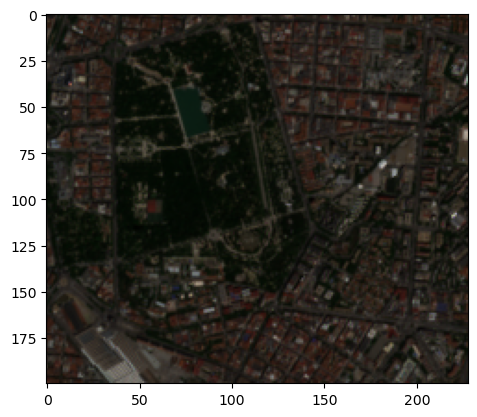

In [130]:
plt.imshow(np.transpose(data[27,:,:,[3,2,1]], (1,2,0)))

#[1,3,7,9,21,22,23,27]

In [164]:
import torch
from src.lightning_modules import LitModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Uncomment to use the CPU
device = 'cpu'

# Uncomment to use the GPU
# device = 'cuda'

print('Using device:', device)
print()

def load_model(checkpoint, device):
    """ Loads a model from a checkpoint.

    Parameters
    ----------
    checkpoint : str
        Path to the checkpoint.

    Returns
    -------
    model : lightning_modules.LitModel
        The model.
    """    
    model = LitModel.load_from_checkpoint(checkpoint).eval()
    return model.to(device)

def run_inference(x, y, checkpoint_path, device):
    """ Run inference given a low-resolution input, the high-resolution ground truth and a checkpoint path.

    Parameters
    ----------
    x : torch.Tensor
        The low-resolution input.
    y : torch.Tensor
        The high-resolution ground truth.
    checkpoint_path : str
        The path to the checkpoint.

    Returns
    -------
    y_hat : torch.Tensor
        The output of the model (super-resolved image).
    """    
    model = load_model(checkpoint_path, device)
    y_hat = model(x)
    baseline = BicubicUpscaledBaseline(
        input_size=x.shape[-2:], chip_size=x.shape[-2:], output_size=y.shape[-2:], device=device
    )
    y_baseline = baseline(x)
    y_hat = bias_adjust(y_hat, y)
    y_baseline = bias_adjust(y_baseline, y)
    return y_hat, y_baseline

def bias_adjust(y_hat, y):
    """ Adjust the bias of the output of the model.

    Parameters
    ----------
    y_hat : torch.Tensor
        The output of the model (super-resolved image).
    y : torch.Tensor
        The ground truth (high-resolution image).

    Returns
    -------
    y_hat : torch.Tensor
        The output of the model (super-resolved image) with bias adjusted.
    """    
    b = (y - y_hat).mean(dim=(-1, -2), keepdim=True)
    return y_hat + b

model = load_model('pretrained_model/model.ckpt', device)


Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file L:\repos\worldstrat\worldstrat\pretrained_model\model.ckpt`


Using device: cpu



c:\Users\aluna\AppData\Local\mambaforge\envs\worldstrat\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(


In [131]:
bands = data
input_data = data[[1,3,7,9,21,22,23,27],:50,:50,:]
input_data = np.transpose(input_data, (0, 3, 1, 2))
input_data = np.expand_dims(input_data, axis=0)  

In [132]:
input_tensor= torch.tensor(input_data, dtype=torch.float32)
input_tensor.shape

torch.Size([1, 8, 12, 50, 50])

In [174]:
y = model(input_tensor)#.detach().numpy()
y_numpy = y.detach().numpy()

In [175]:
np.shape(y)

torch.Size([1, 1, 3, 156, 156])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


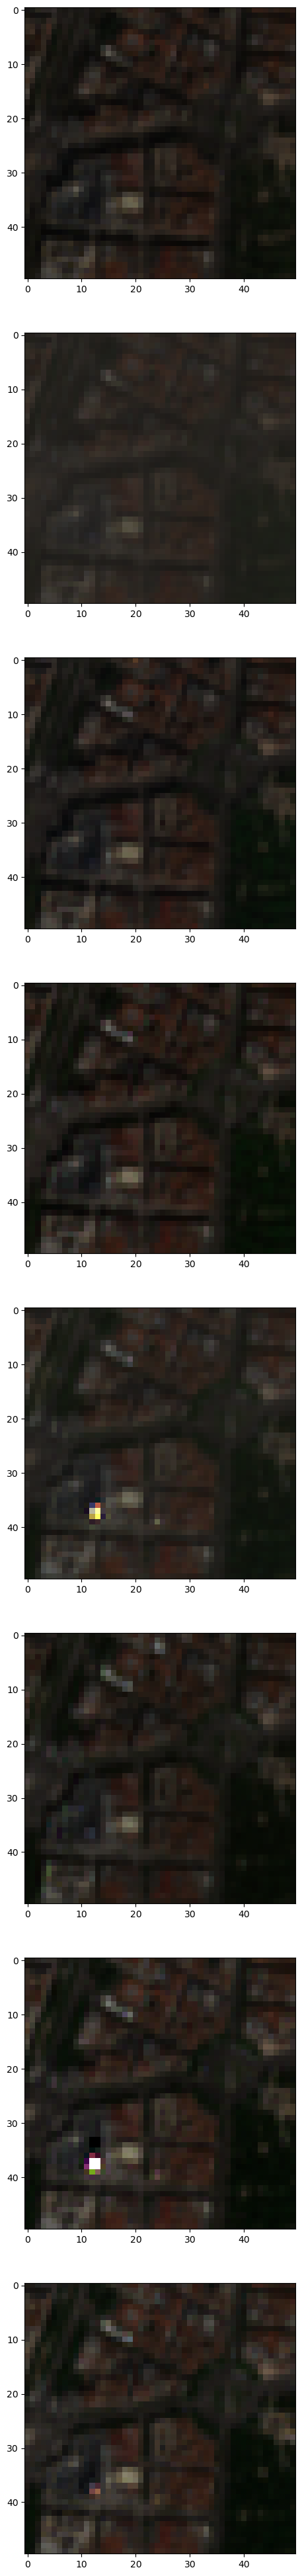

In [176]:
fig,ax = plt.subplots(8, figsize=(50,50))

for idx,x in enumerate(np.squeeze(input_data)):
    #print(f'Plotting {idx}')
    ax[idx].imshow(x.transpose(1, 2, 0)[:,:,[3,2,1]])

In [179]:
import torch
import torch.nn.functional as F

np.shape(input_tensor)
output_tensor = F.interpolate(input_tensor[:,0,[3,2,1],:,:], size=( 156, 156), mode='bilinear', align_corners=False)
np.shape(output_tensor)

b = (output_tensor - y).mean(dim=(-1, -2), keepdim=True)
y = bias_adjust(y, output_tensor).detach().numpy()

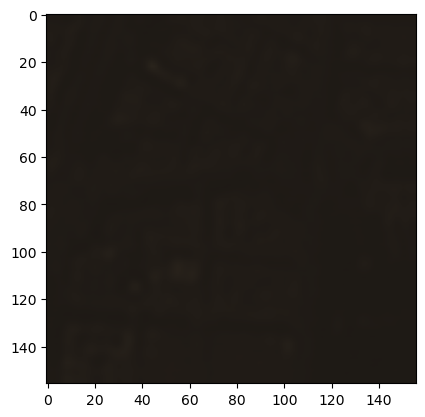

In [180]:
import matplotlib.pyplot as plt

y_res = np.squeeze(y).transpose(1, 2, 0)
plt.imshow(y_res,vmin=np.min(y_res), vmax=np.max(y_res))


In [181]:
y_res

array([[[0.12406553, 0.10514717, 0.08683679],
        [0.12361084, 0.10502383, 0.08669063],
        [0.12317751, 0.10490158, 0.08654772],
        ...,
        [0.12385883, 0.10469785, 0.08638143],
        [0.12350659, 0.10465985, 0.08634105],
        [0.12318017, 0.1046508 , 0.08632565]],

       [[0.12312134, 0.10464261, 0.08643488],
        [0.12289339, 0.10451242, 0.08632343],
        [0.12266568, 0.10437752, 0.08621124],
        ...,
        [0.12282996, 0.10410308, 0.08596893],
        [0.1227388 , 0.10409825, 0.08595579],
        [0.12268251, 0.1041252 , 0.08596466]],

       [[0.12231682, 0.10423668, 0.08609   ],
        [0.12231842, 0.1041143 , 0.08603421],
        [0.12229492, 0.10397749, 0.08597043],
        ...,
        [0.12181687, 0.10351493, 0.08555169],
        [0.12197276, 0.10354423, 0.08556633],
        [0.12217004, 0.1036067 , 0.08559909]],

       ...,

       [[0.12294576, 0.10452779, 0.08638284],
        [0.12248294, 0.10438322, 0.08623821],
        [0.12193321, 0